# Spotify Data Project

Authored by Nick Ivory
Version 1.0
5/18/25

## Project Overview - Exploratory Data Analysis with Spotify API Data

-----
I wanted to build a project that would help me learn and explore three subject areas:
- Proof of Concept 
- Using Polars' columnar data format to investigate performance improvements over Pandas
- Principal Component Analysis, to determine hidden insights into the underlying dataset

In lieu of actually accessing Spotify's open API, I used the following Kaggle dataset: [Spotify Tracks DB](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db/data)

I set out to answer the following questions:
> "How does tempo vary by genre?"
> "What is the distribution of track popularity across decades?"
> "Are danceability and energy correlated?"
> "Which genres tend to have longer or shorter songs?"
> "How has loudness changed over time?"


-----

## Install Dependencies

In [2]:
!pip install -r ../requirements.txt

In [3]:
# Install dependencies as needed:
!pip install 'kagglehub[pandas-datasets]'
!pip install 'kagglehub[polars-datasets]'

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kagglehub]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.5/32.5 MB 13.2 MB/s eta 0:00:0000:0100:01


## Import Library Dependencies

In [44]:
import os
import gc
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

## Import Kaggle Dataset Using Pandas

In [27]:
# Set the path to the file you'd like to load
file_path = "SpotifyFeatures.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zaheenhamidani/ultimate-spotify-tracks-db",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/var/folders/4v/4nbj6pg96h3c8v4mjpv3wd340000gn/T/ipykernel_16150/1261988224.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737     

## Import Kaggle Dataset Using Polars

In [6]:
# Set the path to the file you'd like to load
file_path = "SpotifyFeatures.csv"

# Load the latest version
lf = kagglehub.load_dataset(
  KaggleDatasetAdapter.POLARS,
  "zaheenhamidani/ultimate-spotify-tracks-db",
  file_path,
  # Provide any additional arguments like
  # sql_query, polars_frame_type, or 
  # polars_kwargs.
  # See the documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpolars
)

print("First 5 records:", lf.collect().head())

/var/folders/4v/4nbj6pg96h3c8v4mjpv3wd340000gn/T/ipykernel_16150/2459104393.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  lf = kagglehub.load_dataset(


First 5 records: shape: (5, 18)
┌───────┬─────────────┬─────────────┬────────────┬───┬────────────┬─────────┬────────────┬─────────┐
│ genre ┆ artist_name ┆ track_name  ┆ track_id   ┆ … ┆ speechines ┆ tempo   ┆ time_signa ┆ valence │
│ ---   ┆ ---         ┆ ---         ┆ ---        ┆   ┆ s          ┆ ---     ┆ ture       ┆ ---     │
│ str   ┆ str         ┆ str         ┆ str        ┆   ┆ ---        ┆ f64     ┆ ---        ┆ f64     │
│       ┆             ┆             ┆            ┆   ┆ f64        ┆         ┆ str        ┆         │
╞═══════╪═════════════╪═════════════╪════════════╪═══╪════════════╪═════════╪════════════╪═════════╡
│ Movie ┆ Henri       ┆ C'est beau  ┆ 0BRjO6ga9R ┆ … ┆ 0.0525     ┆ 166.969 ┆ 4/4        ┆ 0.814   │
│       ┆ Salvador    ┆ de faire un ┆ KCKjfDqeFg ┆   ┆            ┆         ┆            ┆         │
│       ┆             ┆ Show        ┆ WV         ┆   ┆            ┆         ┆            ┆         │
│ Movie ┆ Martin &    ┆ Perdu       ┆ 0BjC1NfoEO ┆ … ┆ 0.08

## Exploratory Data Anlysis Using Pandas

### Cleanse, Wrangle, Prep the Kaggle Data

In [36]:
df.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [37]:
#Normalize the apostrophes in genre to reduce data errors
df['genre'] = df['genre'].str.replace('’', "'", regex=False)

## Question 1: "How Does Tempo Vary By Genre?"

In [38]:
df1 = df.dropna(subset=['genre', 'tempo']) #filter out unused columns for analysis

#Remove outliers: Determine which genres have low numbers of tracks
genre_counts = df1['genre'].value_counts() #count how many times each genre appears in dataframe
common_genres = genre_counts[genre_counts > 100].index #filter out genres with less than 100 occurrences
df1 = df1[df1['genre'].isin(common_genres)] #index dataframe according to above criterion

#Retrieve Statistical Measures (min, max, std etc.) and group by genre and tempo
tempo_by_genre = df1.groupby('genre')['tempo'].describe()

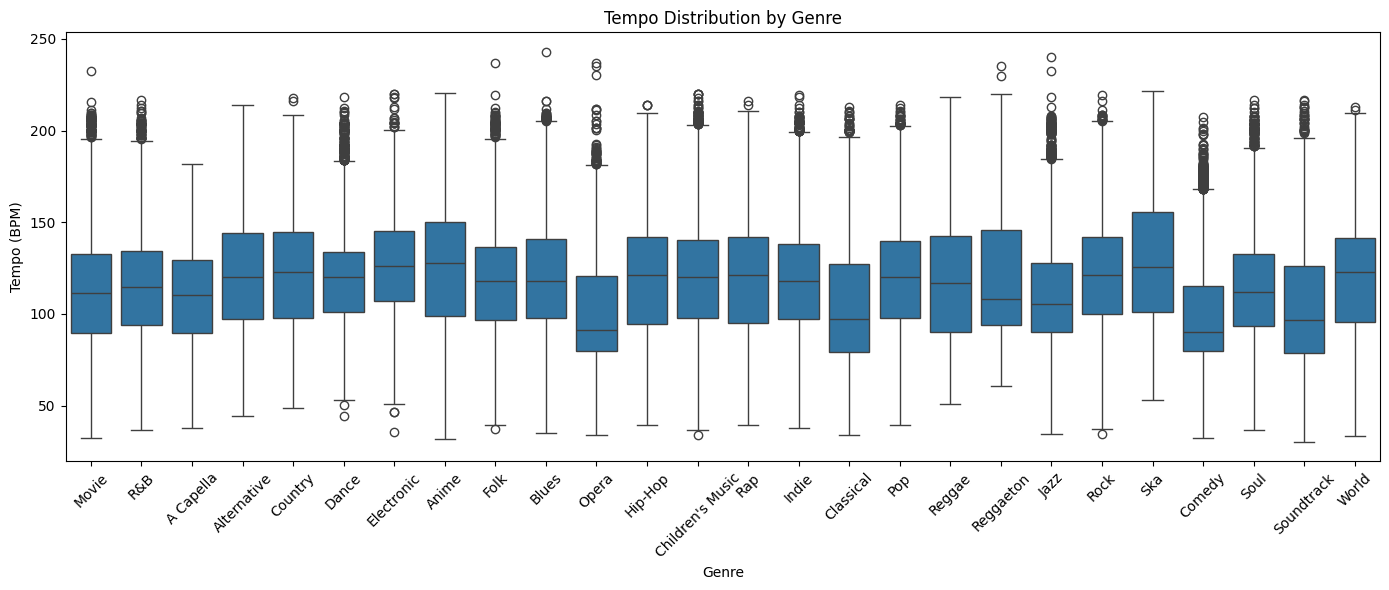

In [39]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df1, x='genre', y='tempo')
plt.xticks(rotation=45)
plt.title('Tempo Distribution by Genre')
plt.ylabel('Tempo (BPM)')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

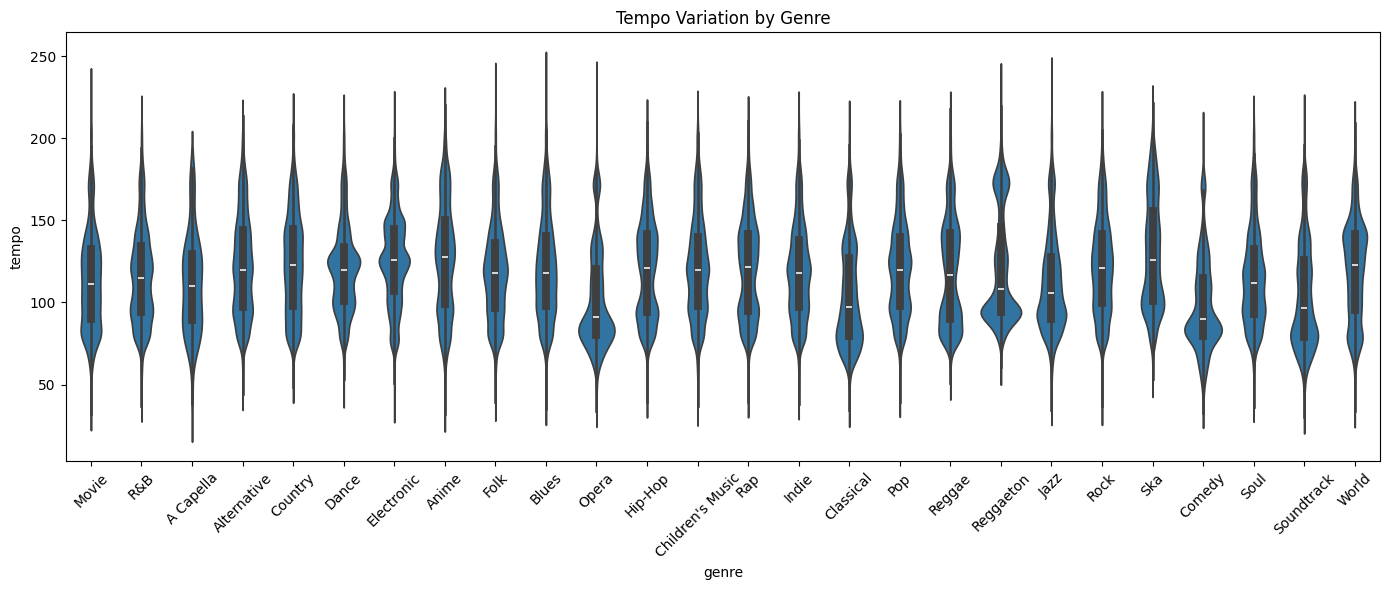

In [35]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=df1, x='genre', y='tempo')
plt.xticks(rotation=45)
plt.title('Tempo Variation by Genre')
plt.tight_layout()
plt.show()

In [41]:
#Clean Up Memory
del df1
gc.collect()

54155

### Question 1: Interpreting the Results - "How Does Tempo Vary By Genre?"

The box plot shows clear tempo clustering by genre, where specific genres like 'Ska' and 'Anime' have lively and consistent tempos (median ~125 BPM), while 'Comedy' and 'Opera' skew lower (median ~90 BPM). Broader spreads in the faster genres suggest more expressive variations in tempo.

The violin plots further illustrate that 'Dance' and 'Electronic' have sharp, dense distributions — indicating many tracks tightly grouped around a single tempo (e.g., 128 BPM, a common dance music standard). 'Hip-Hop' and 'Rap' generally show a wider distribution around 85–95 BPM, supporting the idea of common rhythmic pacing across the genres. In contrast, 'Reggaeton' and 'Rock' exhibit multi-modal or flat distributions (respectively), indicating diversity in tempo usage across sub-genres.

These findings suggest that tempo is a strong genre signal for some styles (like 'Dance'), while others like 'Jazz' embrace more variation in tempo.
****

## Question 2: "What is the distribution of track popularity across decades?"

A word on the author's methodology: The Kaggle dataset that I started out with doesn't have a temporal component indicating release dates. So instead of cut my losses, I endeavoured to try out the [Spotify developer API](https://developer.spotify.com/), and join my dataset to the release data information using the 'track_id' column. 

In [43]:
!pip install spotipy python-dotenv

In [45]:
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Load credentials from .env
load_dotenv()
client_id = os.getenv('SPOTIPY_CLIENT_ID')
client_secret = os.getenv('SPOTIPY_CLIENT_SECRET')

# Authenticate
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)


In [ ]:
import time

def get_release_year(track_name, artist_name):
    try:
        query = f"track:{track_name} artist:{artist_name}"
        results = sp.search(q=query, type='track', limit=1)
        items = results['tracks']['items']
        if items:
            release_date = items[0]['album']['release_date']
            return release_date[:4]  # just the year
        return None
    except Exception as e:
        print(f"Error for {track_name} by {artist_name}: {e}")
        return None


In [ ]:
#Clean Up Memory
del df2
gc.collect()

### Question 2: Interpreting the Results - "What is the distribution of track popularity across decades?"


****

## Question 3: ""